In [1]:
import os
import osmnx as ox
import pandas as pd
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
# quetzal-specific stuff
from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder
from quetzal.io.gtfs_reader import importer
from quetzal.model import stepmodel

input_folder = 'C:\\Users\\BSE\\Documents\\MaxVonMylius\\InfraTrain\\'
os.chdir(input_folder)

print("Successfully imported packages.")

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.
Successfully imported packages.


## Zones

Load zone data from the input files

original crs:  epsg:25833
<class 'shapely.geometry.polygon.Polygon'>


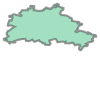

In [2]:
zones = gpd.read_file(r'./data/geo/Ortsteile.shp')
print("original crs: ",zones.crs)
zones = zones.to_crs(epsg = 4326)
buff = 1e-3 # set value high enough that the result will be a single polygon instead of multipolygon
hull = zones["geometry"].buffer(buff).unary_union
# geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
print(type(hull))
hull

## Road network

Build the road network graph from OpenStreetMap data and save it into GeoDataFrames

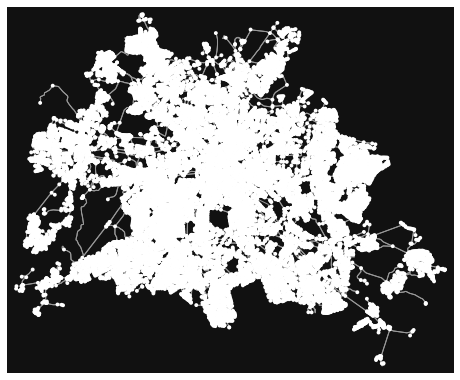

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
drive = ox.graph_from_polygon(hull, network_type='drive')
# Plot it
ox.plot_graph(drive)

In [4]:
# Use OSMNX function to create GeoDataFrames from graph
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [5]:
road_nodes = road_nodes.reset_index()

In [6]:
# Let's have a look at the results
road_nodes.head(5)

,osmid,y,x,street_count,ref,highway,geometry
0,172539,52.565205,13.335501,3,NaN,NaN,POINT (13.33550 52.56521)
1,172545,52.567033,13.346605,4,NaN,NaN,POINT (13.34661 52.56703)
2,172546,52.567738,13.352255,3,NaN,NaN,POINT (13.35225 52.56774)
3,172547,52.564077,13.339564,3,NaN,NaN,POINT (13.33956 52.56408)
4,172549,52.563398,13.342901,3,NaN,NaN,POINT (13.34290 52.56340)


In [7]:
road_links = road_links.reset_index()

In [8]:
road_links.head(2)

,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,lanes,ref,bridge,tunnel,junction,width,access,service,est_width,area
0,172539,34694265,0,4610047,Holländerstraße,tertiary,50,False,237.653,"LINESTRING (13.33550 52.56521, 13.33560 52.565...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172539,34694336,0,5117633,Gotthardstraße,secondary,50,False,687.484,"LINESTRING (13.33550 52.56521, 13.33565 52.565...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

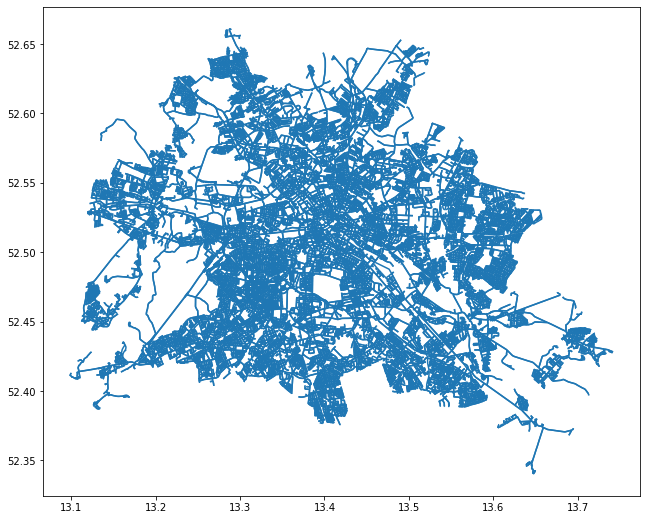

In [9]:
road_links.plot(figsize=(16,9))

In [10]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data
dataTypeSeries = road_nodes.dtypes
print(dataTypeSeries)

osmid              int64
y                float64
x                float64
street_count       int64
ref               object
highway           object
geometry        geometry
dtype: object


In [11]:
# Rename columns and make them type string for later operations
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
#road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

In [12]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])
# Apply the function to all our links
road_links['geometry'] = road_links['geometry'].apply(simplify_link)

In [13]:
# Create a cleaner object and run cleaning functions on it
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [14]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#oc.clean_geometries() # Doesn't work, but let's hope we don't need it
oc.fix_nodeset_consistency()

Our road network is now saved in oc.nodes and oc.links

## Public Transport
For PT, we need to convert GTFS feeds into links and nodes GeoDataFrames

In [15]:
pwd

'C:\\Users\\BSE\\Documents\\MaxVonMylius\\InfraTrain'

In [16]:
# Load the GTFS feed
#full_feed = importer.GtfsImporter(path=input_folder + r'/IDFM_gtfs.zip', dist_units='m') 
full_feed = importer.GtfsImporter(path=input_folder + r'/data/de_oeffnahverkehr.zip', dist_units='m') 
# downloaded from https://data.iledefrance-mobilites.fr/explore/dataset/offre-horaires-tc-gtfs-idf/table/

#print (full_feed)

In [17]:
#print (full_feed)
#full_feed = full_feed.reset_index()
#full_feed.head(5)
full_feed.describe()

,indicator,value
0,agencies,"[Arriva NL, SWE Stadtwerke Emden, Omnibusverke..."
1,running_services,"[62, 3, 135, 134, 88, 12, 138, 125, 6, 24, 113..."
2,timezone,Europe/Berlin
3,start_date,20211017
4,end_date,20211024
5,num_routes,19569
6,num_trips,1264478
7,num_stops,441830
8,num_shapes,0
9,num_frequencies,0


In [18]:
# And we can restrict it spacially if we write a suitable function
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    # f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
     #f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [19]:
full_feed.stops['parent_station'] = 0


In [20]:
# GTFS feeds are very complex. Have a look at Wikipedia for its structure
# We neet to perform some operations in order to transform it into a graph
feed = feed_r.copy()
feed.trips['shape_id'] = 0


NameError: name 'feed_r' is not defined

In [60]:
# Restrict to core hours
time_range = ['07:00:00', '09:00:00'] 
dates = ['20211019']
feed = feed.restrict(time_range=time_range, dates=['20211019'])

In [61]:
# Give the hourly restricted feed to the spatial restriction
feed = spatial_restrict(full_feed, polygon=hull, how='inner')

In [63]:
# Transform it into a graph
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterise stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters


In [64]:
feed.describe()

,indicator,value
0,agencies,"[Barnimer Busges. (ab 30.05.99), Oberhavel Ver..."
1,running_services,"[63, 41, 87, 21, 54, 17, 123, 80, 43, 46, 70, ..."
2,timezone,Europe/Berlin
3,start_date,20211017
4,end_date,20211024
5,num_routes,348
6,num_trips,4485217
7,num_stops,7720
8,num_shapes,0
9,num_frequencies,0


In [66]:
help(feed)

Help on GtfsImporter in module quetzal.io.gtfs_reader.importer object:

class GtfsImporter(quetzal.io.gtfs_reader.feed_gtfsk.Feed)
 |  GtfsImporter(epsg=None, *args, **kwargs)
 |  
 |  An instance of this class represents a not-necessarily-valid GTFS feed,
 |  where GTFS tables are stored as DataFrames.
 |  Beware that the stop times DataFrame can be big (several gigabytes),
 |  so make sure you have enough memory to handle it.
 |  
 |  Primary instance attributes:
 |  
 |  - ``dist_units``: a string in :const:`.constants.DIST_UNITS`;
 |    specifies the distance units to use when calculating various
 |    stats, such as route service distance; should match the implicit
 |    distance units of the ``shape_dist_traveled`` column values,
 |    if present
 |  - ``agency``
 |  - ``stops``
 |  - ``routes``
 |  - ``trips``
 |  - ``stop_times``
 |  - ``calendar``
 |  - ``calendar_dates``
 |  - ``fare_attributes``
 |  - ``fare_rules``
 |  - ``shapes``
 |  - ``frequencies``
 |  - ``transfers``


In [65]:
feed_freq = feed.convert_to_frequencies(time_range=time_range)
# Build links and nodes now from the frequency graph
feed_freq.build_links_and_nodes()
feed_freq.build_geometries(use_utm=False)

AssertionError: 
        Your GTFS still contains 89 services. You must select one date
        or one service before converting to frequencies.
    

In [39]:
help(feed.convert_to_frequencies)

Help on method convert_to_frequencies in module quetzal.io.gtfs_reader.frequencies:

convert_to_frequencies(time_range, pattern_column='pattern_id') method of quetzal.io.gtfs_reader.importer.GtfsImporter instance
    Given:
        - a clean feed defined on one day / one service
        - a time range
    Returns a new feed, converted to frequencies



In [42]:
help(feed.restrict)

Help on method restrict in module quetzal.io.gtfs_reader.filtering:

restrict(dates=None, service_ids=None, time_range=None, trip_ids=None, polygon_4326=None, drop_unused=True) method of quetzal.io.gtfs_reader.importer.GtfsImporter instance



In [43]:
feed = feed_r.copy()
feed.trips['shape_id'] = 0

# Restrict to core hours
time_range = ['07:00:00', '09:00:00'] 
dates = ['20211019']
feed = feed.restrict(time_range=time_range, dates=['20211019'])
# Give the hourly restricted feed to the spatial restriction
feed = spatial_restrict(full_feed, polygon=hull, how='inner')
# Transform it into a graph
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterise stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters
feed.describe()

,indicator,value
0,agencies,"[Barnimer Busges. (ab 30.05.99), Oberhavel Ver..."
1,running_services,"[63, 41, 87, 21, 54, 17, 123, 80, 43, 46, 70, ..."
2,timezone,Europe/Berlin
3,start_date,20211017
4,end_date,20211024
5,num_routes,348
6,num_trips,90871
7,num_stops,7720
8,num_shapes,0
9,num_frequencies,0


In [56]:
feed = feed_r.copy()
feed.trips['shape_id'] = 0

# Restrict to core hours
time_range = ['07:00:00', '09:00:00'] 
dates = ['20211019']
feed = feed.restrict(time_range=time_range, dates=dates)
# Give the hourly restricted feed to the spatial restriction
feed = spatial_restrict(full_feed, polygon=hull, how='inner')
# Transform it into a graph
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterise stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters
feed.describe()

,indicator,value
0,agencies,"[Barnimer Busges. (ab 30.05.99), Oberhavel Ver..."
1,running_services,"[63, 41, 87, 21, 54, 17, 123, 80, 43, 46, 70, ..."
2,timezone,Europe/Berlin
3,start_date,20211017
4,end_date,20211024
5,num_routes,348
6,num_trips,90871
7,num_stops,7720
8,num_shapes,0
9,num_frequencies,0


In [57]:
feed = feed_r.copy()
feed.trips['shape_id'] = 0

# Restrict to core hours
time_range = ['07:00:00', '09:00:00'] 
dates = ['20211019']
feed = feed.restrict(time_range=time_range)
# Give the hourly restricted feed to the spatial restriction
feed = spatial_restrict(full_feed, polygon=hull, how='inner')
# Transform it into a graph
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterise stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters
feed.describe()

,indicator,value
0,agencies,"[Barnimer Busges. (ab 30.05.99), Oberhavel Ver..."
1,running_services,"[63, 41, 87, 21, 54, 17, 123, 80, 43, 46, 70, ..."
2,timezone,Europe/Berlin
3,start_date,20211017
4,end_date,20211024
5,num_routes,348
6,num_trips,90871
7,num_stops,7720
8,num_shapes,0
9,num_frequencies,0


In [58]:
full_feed.describe()

,indicator,value
0,agencies,"[Arriva NL, SWE Stadtwerke Emden, Omnibusverke..."
1,running_services,"[63, 33, 87, 17, 80, 121, 118, 138, 77, 73, 12..."
2,timezone,Europe/Berlin
3,start_date,20211017
4,end_date,20211024
5,num_routes,19569
6,num_trips,1264478
7,num_stops,441830
8,num_shapes,0
9,num_frequencies,0


In [ ]:
feed_frequencies.links.head(2)

In [ ]:
feed_frequencies.nodes.head(1)

In [ ]:
# Make stop_id the unique index of nodes
# Use cluster_id if you built clusters before
feed_frequencies.nodes.set_index('stop_id', inplace=True)
len(feed_frequencies.nodes.loc[feed_frequencies.nodes.index.duplicated()])

In [ ]:
# Rename the route types
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

In [ ]:
# Plot the results using matplotlib notation
ax = zones.plot(alpha=0.5, figsize=[17, 7])
ax = feed_frequencies.links.plot(linewidth=0.5, color='green', ax=ax)
plot= feed_frequencies.nodes.plot(markersize=0.5, color='red', ax=ax)

## Create the transport model
We have the network DataFrames and need to put them into a model now, to be able to run quetzal functions on it, that go beyond the scope of only one DataFrame

In [ ]:
# Create the model with Coordinate Reference System 4326
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')

In [ ]:
# Save zones into the model
sm.zones = zones

In [ ]:
# Add road network
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway']]
sm.road_nodes = oc.nodes[['geometry']]

In [ ]:
# Assign PT network to it with the columns we need
sm.links = feed_frequencies.links[['trip_id', 'a', 'b', 'link_sequence', 'time', 'headway',
                                   'pattern_id', 'route_id', 'service_id', 'direction_id',
                                   'agency_id', 'route_type', 'geometry']]
sm.nodes = feed_frequencies.nodes[['geometry', 'stop_name']]

## Check integrity
Run quetzals integrity check functions to see if the networks are alright

In [ ]:
# check and fix name collision in the indicies
sm.integrity_fix_collision()

In [ ]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

In [ ]:
# Fix PT
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

In [ ]:
# Test
sm.integrity_test_all(errors='raise')

## Cluster PT stops
Clustering has the advantage of reducing the model's file size and computational expenses. You can also leaf this step out.

In [ ]:
len(sm.nodes)


In [ ]:
# Clusterize nodes
sm.preparation_clusterize_nodes(n_clusters=300)
sm.nodes.head(1)

In [ ]:
len(sm.nodes)

In [ ]:
# Now, some links might go from one stop to the same
sm.links = sm.links.loc[sm.links['a']!=sm.links['b']]

In [ ]:
# Fix network integrity again
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()

In [ ]:
# Check the integrity again
sm.integrity_test_all(errors='raise')

In [ ]:
# Re-index nodes to prevent collision
sm.nodes.index = ['n_'+str(i) for i in sm.nodes.index]
sm.links['a'] = 'n_' + sm.links['a'].astype(str)
sm.links['b'] = 'n_' + sm.links['b'].astype(str)

In [ ]:
sm.links.sample()

## Network connectors
We have road and PT links and nodes. Now we need to connect them for people to be able to switch and enter as they want

In [ ]:
# Create a footpaths table
sm.preparation_footpaths(max_length=1000, n_clusters=300)
sm.footpaths.head(3)

In [ ]:
len(sm.footpaths)

In [ ]:
# Create access and egress links (ntlegs)
threshold = 200
sm.preparation_ntlegs(
    short_leg_speed=3, # km/h
    long_leg_speed=7, # km/h
    threshold=threshold, # m
    zone_to_transit=True, # zone centroid - PT connectors
    zone_to_road=True, # zone centroid - road connectors
    n_ntlegs=5 # number of connectors
)

In [ ]:
# This is how the new tables look like
# Re-index them too
sm.zone_to_transit.index = ['ztt_'+str(i) for i in sm.zone_to_transit.index]
sm.zone_to_transit.sample(1)

In [ ]:
sm.zone_to_road.index = ['ztr_'+str(i) for i in sm.zone_to_road.index]
sm.zone_to_road.sample(1)

In [ ]:
sm.road_to_transit.index = ['rtt_'+str(i) for i in sm.road_to_transit.index]
sm.road_to_transit.sample(1)

## Save the model
We have a complete network with connectors. Now save it.

quetzal provides two functions. One is the to_zip (and read_zip for loading again), which is very fast, but the file format is hdf5, which is not compatible with other programs.

The other option is to_json (and read_json), which saves tables as GeoJSON format. This is great to look at them in GIS software like QGIS, but it is slower for larger models.

Both functions take the location string as a first argument and optionally the only_attributes argument, where you can pass a list of table names that should be saved. All others are discarded.

In [ ]:
sm.to_json('./data/outputs/network')